## Introduction
This notebook takes the master data file produced in the earlier ED_Future notebook ('..\data\Futures\ed_master.csv') 
and creates a concatenated file of futures contracts containing your chosen maturities. EG when do you want to roll? 
How long dated do you want to go? Do you want to test / trade the front contract only? A contract a year out? 4 years out?
Back in 1982 there was not much choice. These days you can trade for delivery four years out.

In [40]:
#Imports
import pandas as pd
import numpy as np
from numba import jit
import os
import ffn
from pandas.tseries.offsets import *
import matplotlib.pyplot as plt
%matplotlib notebook

In [41]:
#read in the master data file produced in the earlier notebook which contains every contract maturity
ed_master = '..\data\Futures\ed_master.csv'

eurodollar = pd.read_csv(
    ed_master,
    header=0,
    parse_dates=["Date", "Start", 'End'],
)

In [42]:
#Add columns which will trigger your choice of contracts
#Don't worry about the nonsensical VAMI. Thgis will get updated when maturites have been chosen
#and the datafile thinned out to only those contract you want to test / trade
eurodollar['DStart'] = eurodollar.Date.eq(eurodollar.Date.shift(1))
eurodollar['DEnd'] = eurodollar.Date.eq(eurodollar.Date.shift(-1))
eurodollar.head()

Date   Open   High    Low  Close  Volume  Open_Interest    Return  \
0 1982-02-02  83.77  84.10  83.77  83.88     941           1126  0.001672   
1 1982-02-02  83.79  84.10  83.76  83.85     941            983  0.001912   
2 1982-02-02  83.80  84.05  83.76  83.85     941            444  0.001912   
3 1982-02-03  83.96  84.10  83.71  83.73     759           1241 -0.001788   
4 1982-02-03  83.97  84.03  83.85  83.89     759           1021  0.000477   

         VAMI Contract      Start        End  DStart   DEnd  
0  100.167184  ED1982H 1982-02-01 1982-03-15   False   True  
1  100.191182  ED1982M 1982-02-01 1982-06-14    True   True  
2  100.191182  ED1982U 1982-02-01 1982-09-13    True  False  
3   99.988058  ED1982H 1982-02-01 1982-03-15   False   True  
4  100.238977  ED1982M 1982-02-01 1982-06-14    True   True

In [60]:
#initialise variables
#what length of expiration are you looking for in days?
expiration = int(400)

In [61]:
#Create a dictionary to store data as you loop through the master file
#and a counter
temp_futures = {}
a = 0

#loop through the master data file
for i, row in enumerate(eurodollar.itertuples(), 0):

    if row.DStart == False:
        #for each trading day initiate the price series with the earliest expiry first. 
        #Find your target expiration date
        #and how wide of your target this first expiry listed for this trading day is
        targetExpiration = row.Date + expiration * Day()
        targetExpirationDifference = abs(targetExpiration  - row.End)
        expirationLocation = (i)

    if row.DStart == True and row.DEnd == True:
        #iterate through the different expirations trading each day
        #find the closest match to targetExpiration
        if abs(targetExpiration - row.End) <= targetExpirationDifference:
            #error correction routine - when diff between target expiration and expiration continues to decline,
            #algo chooses the closer expirataion
            targetExpirationDifference = abs(targetExpiration - row.End)
            expirationLocation = (i)
            #closest expiration to your target expiration has now been chosen. 
        
    if row.DEnd == False:
        #Now you have reached the last contract trading on the relevant trading day
        if abs(targetExpiration - row.End) <= targetExpirationDifference:
            #error correction routine - when diff between target expiration and expiration continues to decline,
            #algo chooses the closer expirataion
            targetExpirationDifference = abs(targetExpiration - row.End)
            expirationLocation = (i)
        #You have now found the closest expiry to your target expiry for a given trading day...
        #So add a row for the day's data for that expiry to the dictionary
        temp_futures[eurodollar.Date[i]] = [
            eurodollar.Date[i], eurodollar.Close[expirationLocation],
            eurodollar.Return[expirationLocation],
            eurodollar.Volume[expirationLocation],
            eurodollar.Contract[expirationLocation],
            eurodollar.Start[expirationLocation],
            eurodollar.End[expirationLocation], targetExpiration,
            targetExpirationDifference
        ]

In [62]:
#This function will calculate the VAMI each day from the return for that day
@jit()
def calculator(a):
    res = np.empty(rolling_eurodollar.VAMI.shape)
    res[0] = 100
    for i in range(1, res.shape[0]):
        res[i] = res[i-1] +(res[i-1]* a[i])
    return res

In [63]:
#Create a dataframe from the dictionary temp_futures
rolling_eurodollar = pd.DataFrame(temp_futures).T
rolling_eurodollar.index.name = 'Date'
rolling_eurodollar.columns = [
    'Date', 'Close', 'Return', 'Volume', 'Contract', 'Start', 'End',
    'targetExpiration', 'targetExpirationDifference'
]
rolling_eurodollar['VAMI']=0.0
#calculate the VAMI for each day
rolling_eurodollar['VAMI'] = calculator(
    *rolling_eurodollar[list(rolling_eurodollar.loc[:, ['Return']])].values.T)

In [64]:
rolling_eurodollar.tail()

Date   Close       Return  Volume Contract  \
Date                                                                    
2019-04-08  2019-04-08 00:00:00   97.68 -0.000204708   82091  ED2020M   
2019-04-09  2019-04-09 00:00:00   97.71  0.000307125   67924  ED2020M   
2019-04-10  2019-04-10 00:00:00   97.73  0.000204687  106436  ED2020M   
2019-04-11  2019-04-11 00:00:00  97.695  -0.00035813   53472  ED2020M   
2019-04-12  2019-04-12 00:00:00  97.625 -0.000716516   53472  ED2020M   

                          Start                  End     targetExpiration  \
Date                                                                        
2019-04-08  2016-06-30 00:00:00  2020-06-15 00:00:00  2020-05-12 00:00:00   
2019-04-09  2016-06-30 00:00:00  2020-06-15 00:00:00  2020-05-13 00:00:00   
2019-04-10  2016-06-30 00:00:00  2020-06-15 00:00:00  2020-05-14 00:00:00   
2019-04-11  2016-06-30 00:00:00  2020-06-15 00:00:00  2020-05-15 00:00:00   
2019-04-12  2016-06-30 00:00:00  2020-06-15 00:00:00  2020-05-16 00:00:00   

           targetExpirationDifference        VAMI  
Date                                               
2019-04-08           34 days 00:00:00  152.649468  
2019-04-09           33 days 00:00:00  152.696351  
2019-04-10           32 days 00:00:00  152.727606  
2019-04-11           31 days 00:00:00  152.672909  
2019-04-12           30 days 00:00:00  152.563517

In [65]:
#Save your time series to csv for retrieval for later backtesting with your chosen program
rolling_eurodollar.to_csv('..\data\Futures/rolling_eurodollar.csv', index=None)

In [66]:
#Create a new dataframe to display the results
ED=rolling_eurodollar[['VAMI']].copy()

In [67]:
#Inspect the final results
ED.tail()

VAMI
Date                  
2019-04-08  152.649468
2019-04-09  152.696351
2019-04-10  152.727606
2019-04-11  152.672909
2019-04-12  152.563517

<IPython.core.display.Javascript object>


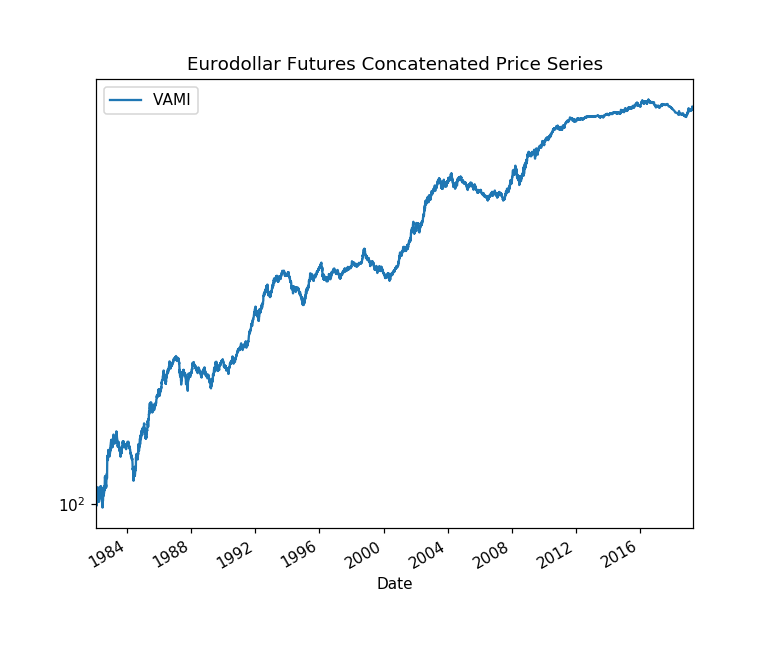

In [68]:
#Chart the final results
log=True
ED.plot(figsize=(7,6),logy=log,title='Eurodollar Futures Concatenated Price Series')

In [69]:
#Produce statistics for the final results
stats = ED.calc_stats()
#Choose different start and end dates if you prefer as per the following coded out line
#ffn.core.GroupStats.set_date_range(stats,start=' 1989-09-18 ', end=start=' 2000-09-18 ')
stats.display()

Stat                 VAMI
-------------------  ----------
Start                1982-02-02
End                  2019-04-12
Risk-free rate       0.00%

Total Return         52.56%
Daily Sharpe         0.82
Daily Sortino        1.37
CAGR                 1.14%
Max Drawdown         -5.15%
Calmar Ratio         0.22

MTD                  -0.15%
3m                   0.12%
6m                   0.70%
YTD                  0.07%
1Y                   0.38%
3Y (ann.)            -0.26%
5Y (ann.)            0.08%
10Y (ann.)           0.47%
Since Incep. (ann.)  1.14%

Daily Sharpe         0.82
Daily Sortino        1.37
Daily Mean (ann.)    1.18%
Daily Vol (ann.)     1.45%
Daily Skew           0.52
Daily Kurt           14.26
Best Day             1.31%
Worst Day            -0.76%

Monthly Sharpe       0.73
Monthly Sortino      1.36
Monthly Mean (ann.)  1.12%
Monthly Vol (ann.)   1.54%
Monthly Skew         -0.01
Monthly Kurt         2.36
Best Month           1.77%
Worst Month          -2.09%

Yearly Sharp

<IPython.core.display.Javascript object>


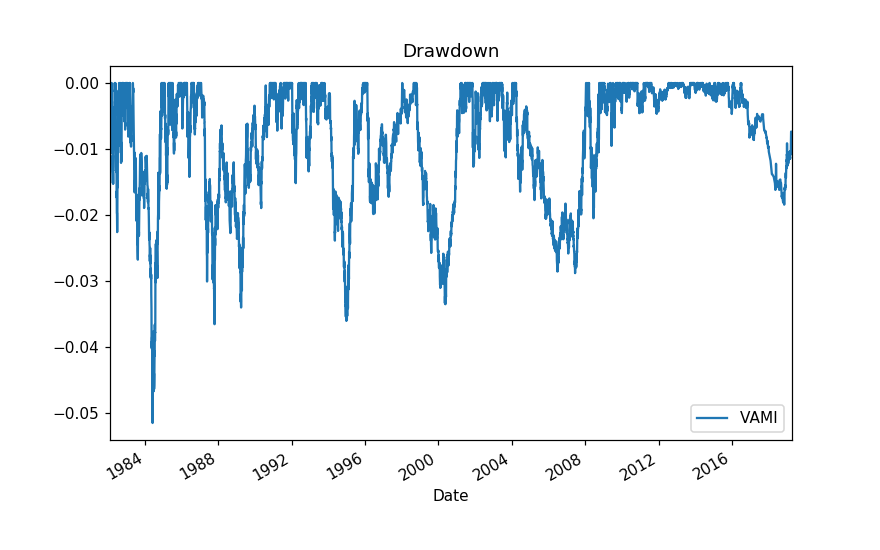

In [70]:
#Produce an "underwater" or "drawdown" chart
drawdown = stats.prices.to_drawdown_series()
drawdown.plot(figsize=(8, 5),logy=False,title='Drawdown')